In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
# Set up initial data
train_df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

In [3]:
train_df_len = len(train_df)
train_df_len

8693

In [4]:
test_df_len = len(test_df)
test_df_len

4277

In [5]:
# Need these to be able to manipulate data better for both the train and test sets
def combine_df(train_df, test_df):
    combined_df = pd.concat([train_df, test_df], ignore_index=True)
    return combined_df

def separate_df(combined_df, train_df_len, test_df_len):
    train_df = combined_df.iloc[:train_df_len]
    test_df = combined_df.iloc[train_df_len:train_df_len + test_df_len]
    return train_df, test_df

full_df = combine_df(train_df, test_df)
len(full_df)

12970

In [6]:
full_df

/opt/conda/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:344: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN
12966,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN
12967,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN
12968,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN


We know that people who are in CryoSleep won't be spending any money, nor will they be buying VIP. So if there are any NaN values for people in CryoSleep in either of those categories, we can just substitute in the values we know they have.

In [7]:
# List the columns we want to change
zero_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
false_columns = ['VIP']

# Condition is met if person is in CryoSleep
condition = (full_df['CryoSleep'] == True)

# Locate all rows with this condition and fill in the values for what we know them to be
full_df.loc[~condition, zero_columns] = full_df.loc[~condition, zero_columns].fillna(0)
full_df.loc[~condition, false_columns] = full_df.loc[~condition, false_columns].fillna(False)

If we know that the people who are in CryoSleep aren't spending any money, then we know that anyone who has NaN for CryoSleep, but is spending money is probably not in CryoSleep, so let's fill in these values as well.

In [8]:
zero_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
cryosleep_column = ['CryoSleep']

# Condition is if all money columns are equal to zero
condition = (full_df[zero_columns].eq(0).all(axis=1))

#  Fill in NaN CryoSleep values as True if condition is met
full_df.loc[~condition, cryosleep_column] = full_df.loc[~condition, cryosleep_column].fillna(True)

Now that we have that out of the way, the only values that should be left in CryoSleep are for people who are not in CryoSleep, so we will fill in the rest of the columns as False.

In [9]:
full_df['CryoSleep'].fillna(False, inplace=True)

In [10]:
full_df.isna().sum()

PassengerId        0
HomePlanet       288
CryoSleep          0
Cabin            299
Destination      274
Age              270
VIP              104
RoomService       93
FoodCourt        109
ShoppingMall     131
Spa              107
VRDeck            91
Name             294
Transported     4277
dtype: int64

Now that the missing values are looking more sparse than previously, we should try to get a visual of the rest of the missing values.

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


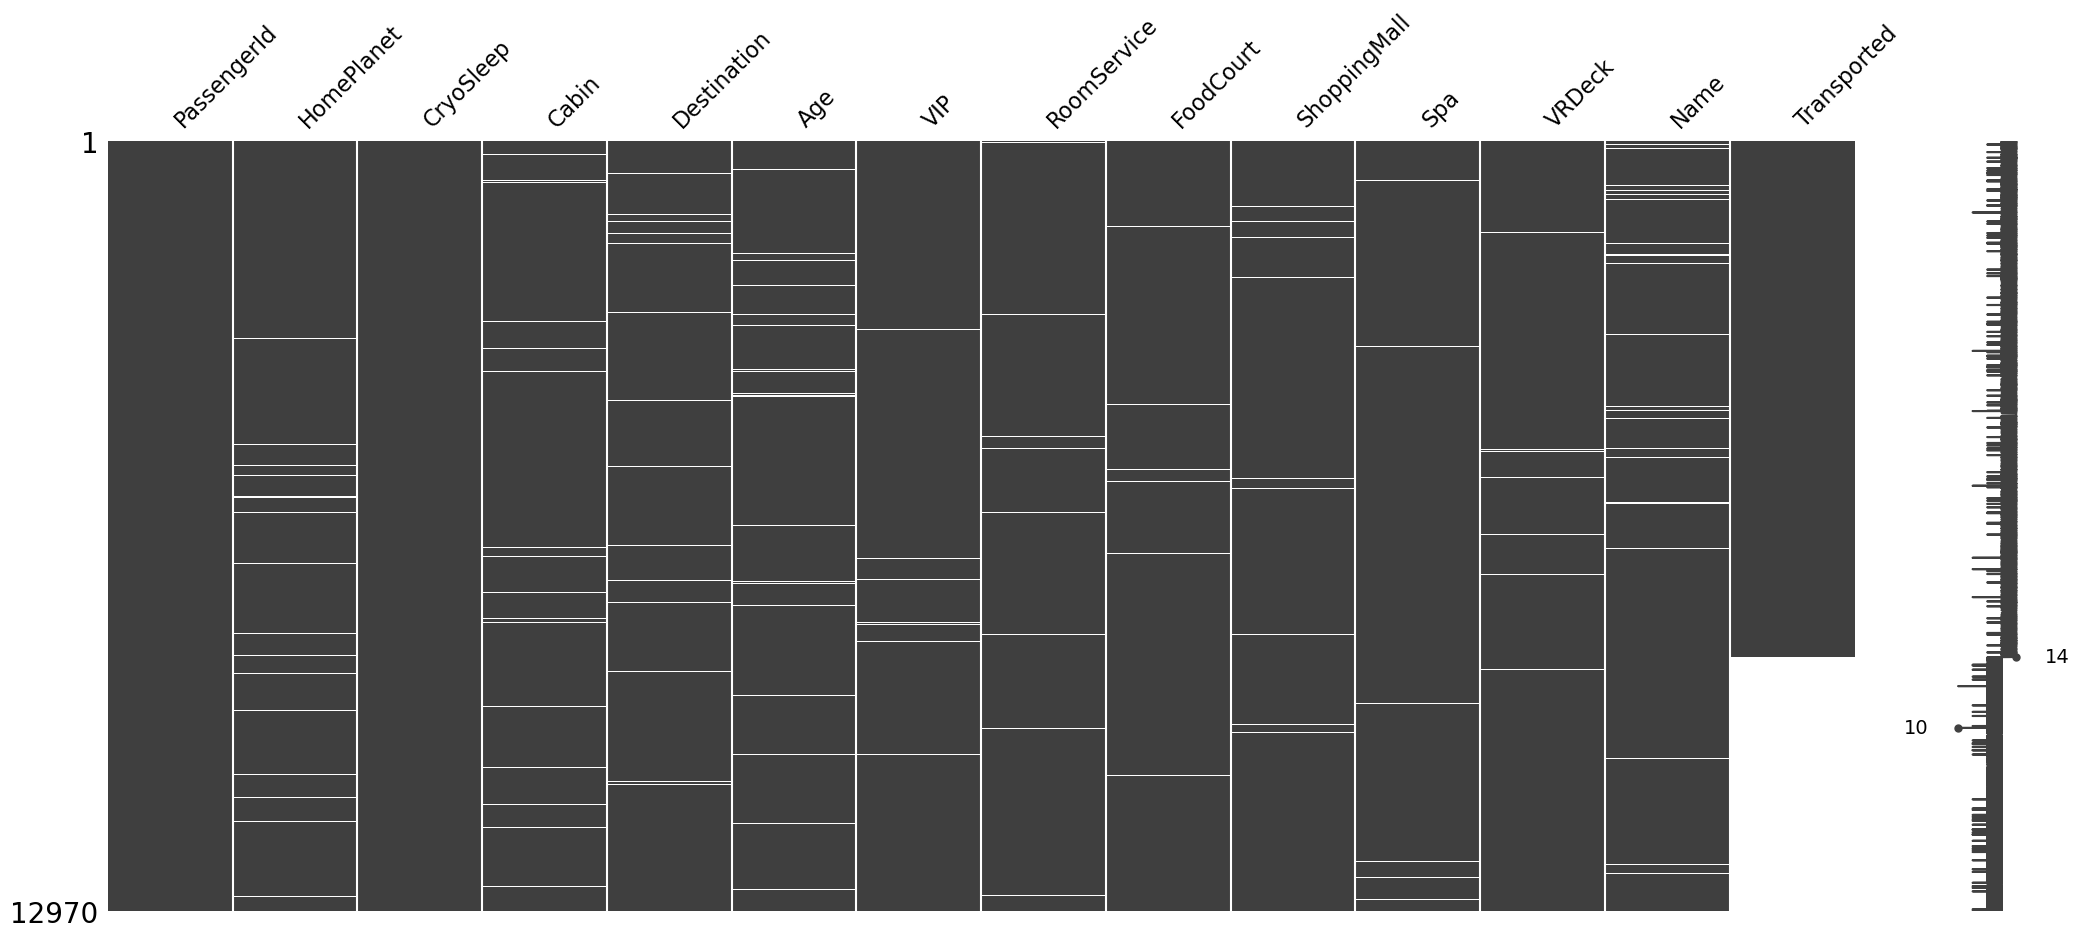

<Figure size 1500x900 with 0 Axes>

In [11]:
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(full_df)
plt.figure(figsize=(15, 9))
plt.show()

The transported column makes sense because the test set has no Transported column.

<Axes: >

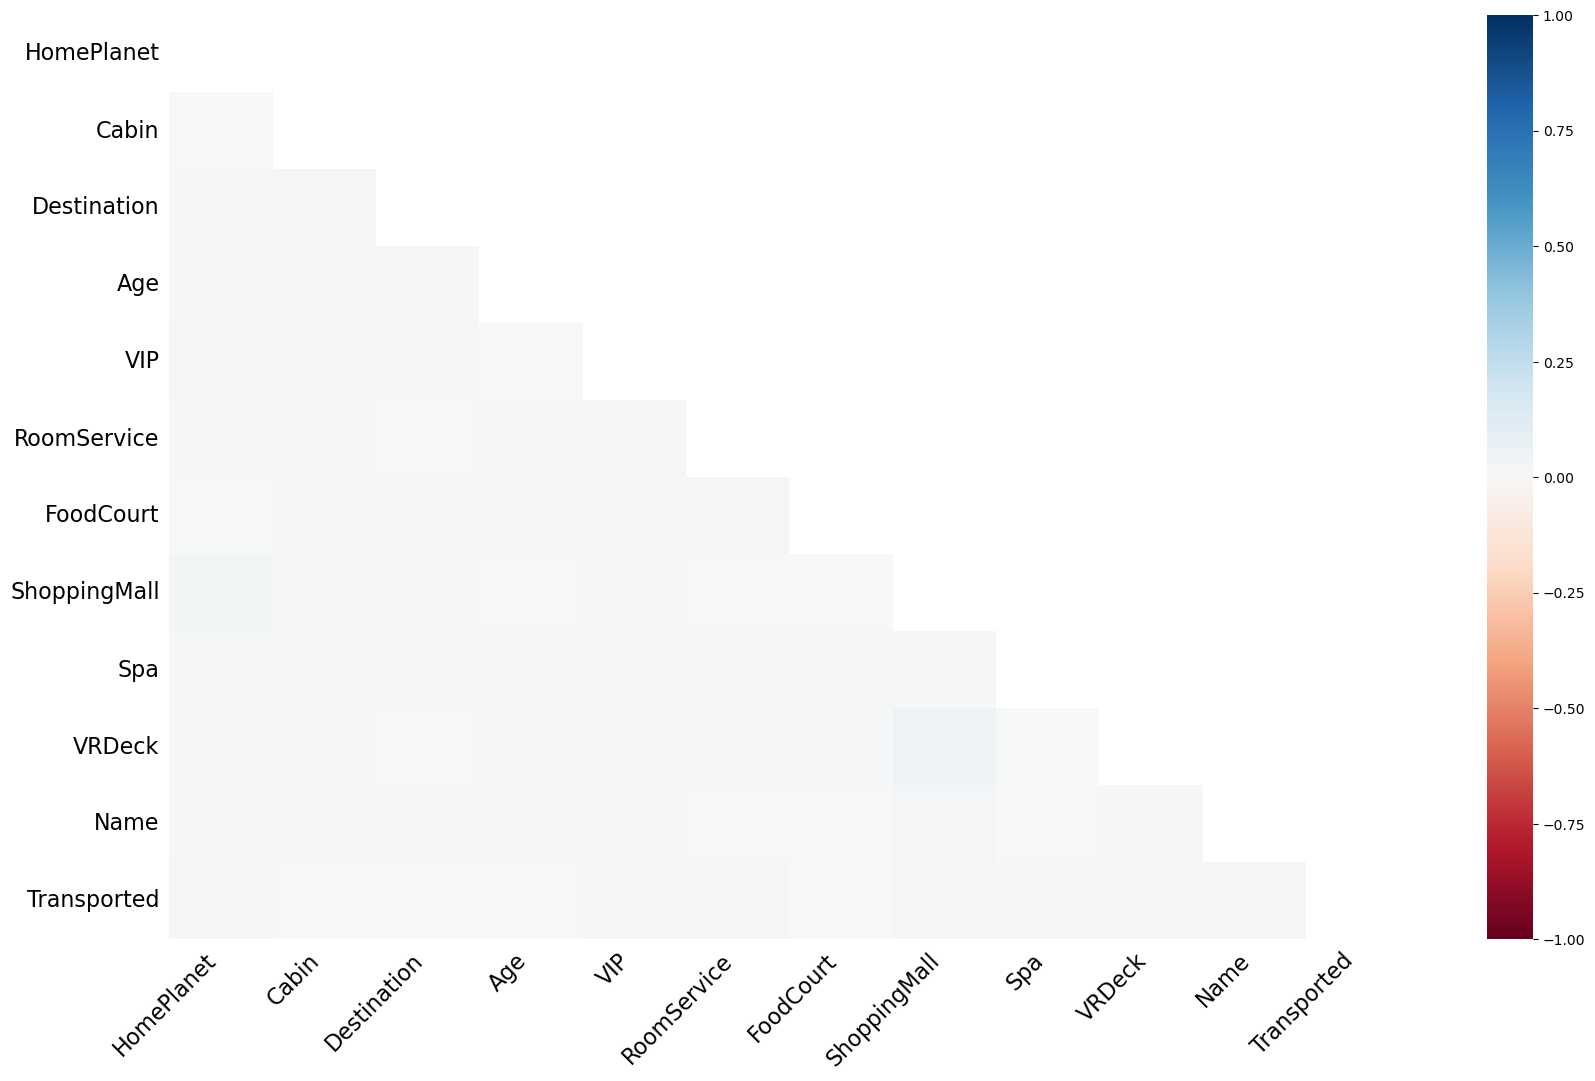

In [12]:
# It looks like the missing values are pretty widespread throughout the data
# Lets get a closer look
msno.heatmap(full_df, labels=True) 

The rest of these code blocks are just for data visualization, feel free to play around with the columns to see which columns have interesting interactions.

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


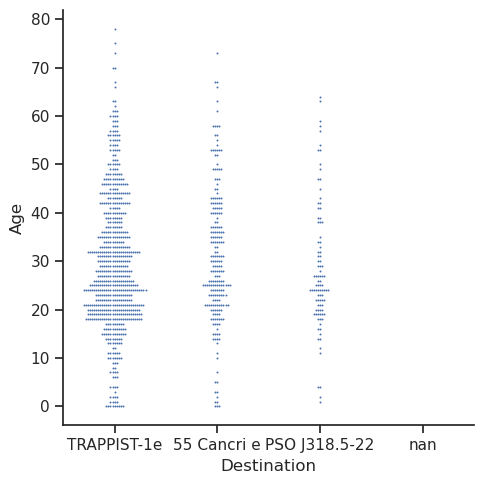

In [13]:
import seaborn as sns
sample_df = full_df.sample(n=1000)

# Age has no effect on being transported
# People who spent more on roomservice were less likely to be transported
# Older people were less likely to use CryoSleep
# Not many VIP's, but the ones who were werent younger than 20
# Europans were typically older than earthlings, most martians were evenly distributed
# Europans spent more on roomservice due to outliers, earthlings spend the least on roomservice, while martians spend more overall
# This metric seems to persist throughout the data
# Most people were going to TRAPPIST, while the least were going to J318


sns.set(style='ticks')
sns.catplot(x='Destination', y='Age', kind='swarm', data=sample_df, s=2)
plt.show()

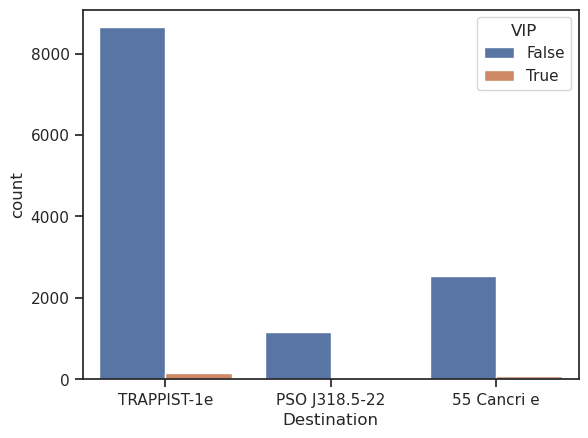

In [14]:
sns.countplot(x='Destination',hue='VIP', data=full_df)
plt.show()
# Nobody chose VIP if they were in CryoSleep, so any people with VIP should have CryoSleep filled in as false
# Most Earthlings were going to Trappist, so just fill in both earth and mars with trappist
# Europa is half and half between trappist and 55 Cancri e, perhaps fill in half with each, otherwise just leave it be

The column for cabin has very important details that will be overlooked of we don't manipulate the column into more columns. Let's split the column into it's respective parts to make this easier on ourselves.

In [15]:
# First, lets separate the data in the cabin column into it's respective pieces of data
cabin_split = full_df['Cabin'].str.split('/', expand=True)
cabin_split.columns = ['Deck', 'Room_Number', 'Side']
new_df = pd.concat([full_df, cabin_split], axis=1)
full_df = new_df
full_df.drop(columns=['Cabin'], inplace=True)
full_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Room_Number,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S


We will need to impute the age column at some point to deal with the missing values. Since this column is probably quite important, we should be careful with how we impute it. I will be filling in the age column based on the average ages of people grouped by HomePlanet and whether or not they are in CryoSleep

In [16]:
group_means = full_df.groupby(['HomePlanet', 'CryoSleep'])['Age'].mean()
print(group_means)

HomePlanet  CryoSleep
Earth       False        27.056735
            True         23.575071
Europa      False        35.488731
            True         32.929037
Mars        False        29.800888
            True         28.934426
Name: Age, dtype: float64


In [17]:
# Fill in NaN values for Age
group_means = full_df.groupby(['HomePlanet', 'CryoSleep'], group_keys=True)['Age'].mean().reset_index(name='Age_mean')
full_df = full_df.merge(group_means, on=['HomePlanet', 'CryoSleep'], how='left')
full_df['Age'] = full_df['Age'].fillna(full_df['Age_mean'])
full_df.drop(columns=['Age_mean'], inplace=True)

In [18]:
full_df.isna().sum()

PassengerId        0
HomePlanet       288
CryoSleep          0
Destination      274
Age                5
VIP              104
RoomService       93
FoodCourt        109
ShoppingMall     131
Spa              107
VRDeck            91
Name             294
Transported     4277
Deck             299
Room_Number      299
Side             299
dtype: int64

The NaN's are looking much better than they were, so let's move onto the rest of the data processing, and then onto models.

In [19]:
# Now we can continue with imputing/preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer


# Specify numerical and categorical features
numerical_features = ['Room_Number', 'Age', 'RoomService', 'FoodCourt','ShoppingMall','Spa','VRDeck']
categorical_features = ['HomePlanet','CryoSleep','Destination','VIP','Deck', 'Side']

# Create preprocessing pipelines for numerical and categorical features
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('inputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_features),
    ('categorical', categorical_pipeline, categorical_features)
])


We are going to continue onto the next steps of separating the DF's back into what they are supposed to be, then we will be starting training for our models. I will be tampering with the parameters on a separate notebook, so the ones you see in this notebook will be better overall from what I test. Just know that there was more going on behind the scenes.

In [20]:
# Separate DF back into respective DF's
train_df, test_df = separate_df(full_df,train_df_len,test_df_len)

# Set up target
y = train_df['Transported']

# Take target out of both train and test sets
train_df.drop(columns=['Transported'], inplace=True)
test_df.drop(columns=['Transported'], inplace=True)

# Y needs to be changed to actual binary values instead of strings
y = y.astype(bool)
y.head()

/tmp/ipykernel_20/755381303.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=['Transported'], inplace=True)
/tmp/ipykernel_20/755381303.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=['Transported'], inplace=True)


0    False
1     True
2    False
3    False
4     True
Name: Transported, dtype: bool

Now we will be transforming our data to be what the ML models will need to predict with our data. This means one hot encoding categorical features, and scaling our numerical features.

In [21]:
# Need this for later
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
SEED = 42

In [22]:
# Shape before transformation
print('X_train shape: {}'.format(train_df.shape))
print('y_train shape: {}'.format(y.shape))
print('X_test shape: {}'.format(test_df.shape))

X_train shape: (8693, 15)
y_train shape: (8693,)
X_test shape: (4277, 15)


In [23]:
# Fit data to preprocessor, and clean the data, rename columns to correct names afterwards
transformed_data_train = preprocessor.fit_transform(train_df)
transformed_data_test = preprocessor.transform(test_df)

feature_names = preprocessor.named_transformers_['categorical'] \
    .named_steps['encoder'].get_feature_names_out(input_features=categorical_features) 

all_feature_names = numerical_features + list(feature_names)

In [24]:
# Turns data into dataframes
transformed_train_df = pd.DataFrame(transformed_data_train, columns = all_feature_names)
transformed_test_df = pd.DataFrame(transformed_data_test, columns = all_feature_names)

In [25]:
# Transformed data check to make sure train and test have same # of categories
print('X_train shape: {}'.format(transformed_train_df.shape))
print('y_train shape: {}'.format(y.shape))
print('X_test shape: {}'.format(transformed_test_df.shape))

X_train shape: (8693, 27)
y_train shape: (8693,)
X_test shape: (4277, 27)


Now onto model selection. For this ensemble model, I will be using a Random Forest model, paired with a Gradient Boosting Classifier. These models play well together, and their predictions will be combined using a Logistic Regression model to give results which fit better overall.

In [26]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# better model overall, performed better on data with less overfitting
#forest_model = RandomForestClassifier(criterion='gini', n_estimators=70, max_depth=5, min_samples_split=2, min_samples_leaf=2,
#                                       max_features='sqrt', random_state=SEED)

# First GBM Model
gbm_model_1 = GradientBoostingClassifier(n_estimators=70, learning_rate=0.1, max_features='sqrt', max_depth=5, random_state=SEED, 
                                        min_samples_split=2, min_samples_leaf=3, loss='exponential', subsample=0.5)

# Second GBM Model
gbm_model_2 = GradientBoostingClassifier(n_estimators=70, learning_rate=0.1, max_features='log2', max_depth=5, random_state=SEED, 
                                        min_samples_split=2, min_samples_leaf=3, subsample=0.5, loss='log_loss')

# Third GBM Model
gbm_model_3 = GradientBoostingClassifier(n_estimators=70, learning_rate=0.1, max_features='log2', max_depth=5, random_state=SEED, 
                                        min_samples_split=2, min_samples_leaf=3, subsample=0.5, loss='exponential')

We now need to split our training data into a train and validation set. This is because I want to test how our ensemble interacts before I implement them. I can always test each model separately to get an overall score, but the two models may interact differently when combined. Feel free to run through this section in order to get to the final result submission. Just make sure you run all the cells, as some of them contain important data for training all of the models.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(transformed_train_df, y, test_size=0.2, random_state=SEED)

In [28]:
from sklearn.metrics import accuracy_score

# Fit both models
gbm_model_1.fit(X_train, y_train)
gbm_model_2.fit(X_train, y_train)
gbm_model_3.fit(X_train, y_train)

# Run through predictions initially to train the Logistic Regression for predicting
gbm_1_predictions = gbm_model_1.predict(X_test)
gbm_2_predictions = gbm_model_2.predict(X_test)
gbm_3_predictions = gbm_model_3.predict(X_test)


# Stack both predictions to form a training set for the Logistic Regression
stacked_features = np.column_stack((gbm_1_predictions, gbm_2_predictions, gbm_3_predictions))

# Fit the meta model to stacked features
meta_model = LogisticRegression()
meta_model.fit(stacked_features, y_test)

# Predict yet again to get a new metric
gbm_1_base_preds = gbm_model_1.predict(X_test)
gbm_2_base_preds = gbm_model_2.predict(X_test)
gbm_3_base_preds = gbm_model_3.predict(X_test)


# Stack both predictions yet again
stacked_base_preds = np.column_stack((gbm_1_base_preds, gbm_2_base_preds, gbm_3_base_preds))

# Get final predictions to gauge overall performance
ensemble_predictions = meta_model.predict(stacked_base_preds)

# Score the predictions and print them
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Ensemble Accuracy:", ensemble_accuracy)

Ensemble Accuracy: 0.80448533640023


Now let's use this model on the final test, and submit it.

In [29]:
# Get new base predictions for actual test set
gbm_1_base_preds = gbm_model_1.predict(transformed_test_df)
gbm_2_base_preds = gbm_model_2.predict(transformed_test_df)
gbm_3_base_preds = gbm_model_3.predict(transformed_test_df)

# Combine both predictions for the meta model to predict
stacked_base_preds = np.column_stack((gbm_1_base_preds, gbm_2_base_preds, gbm_3_base_preds))

In [30]:
# Actually predict the final result
ensemble_predictions = meta_model.predict(stacked_base_preds)

And there you have it. If you found this at all helpful please consider upvoting the notebook, and feel free to share any thoughts about the notebook in the comments.

In [31]:
output = pd.DataFrame({
    'PassengerId' : test_df['PassengerId'],
    'Transported' : ensemble_predictions
})
output.to_csv('submission.csv', index=False)
print('Submission Saved')

Submission Saved
